# Data exploration

In [1]:
import datasets

dataset = datasets.load_dataset('eve-esa/eve-cpt-sample-v0.2')['train']

/Users/antoniolopez/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def sample_dataset(dataset: datasets.Dataset, num_bins: int, n_samples: int = 1000):
    """
    Sample the dataset accordingly to the distribution of the lengths of the examples.
    :param dataset: 
    :param num_bins: 
    :param n_samples: 
    :return: 
    """
    lengths = np.array([get_length(example) for example in dataset])
    hist, bin_edges = np.histogram(lengths, bins=num_bins, density=True)

    # Assign each example to a bin
    bin_indices = np.digitize(lengths, bins=bin_edges, right=True)
    
    # Sample from each bin proportionally
    sampled_indices = []
    for i in range(1, num_bins + 1):
        bin_members = np.where(bin_indices == i)[0]
        if len(bin_members) > 0:
            num_samples = int(n_samples * len(bin_members) / len(lengths))
            sampled_indices.extend(np.random.choice(bin_members, size=num_samples, replace=False).tolist())
    
    
    if len(sampled_indices) > n_samples:
        # Ensure exactly 1000 samples
        sampled_indices = np.random.choice(sampled_indices, size=n_samples, replace=False)
        
    return dataset.select(sampled_indices)


# Load dataset (replace with your dataset)

# Define a function to compute length of each example
def get_length(text: str):
    return len(text.split())  # Change to len(example["text"]) for character length

def plot_lengths(texts: list[str], num_bins=50):
    # Compute lengths
    lengths = np.array([get_length(text) for text in texts])
    
    # Print bins ranges and counts
    hist, bin_edges = np.histogram(lengths, bins=num_bins, density=False)
    for i in range(len(bin_edges) - 1):
        print(f"Bin {i}: [{bin_edges[i]:.0f}, {bin_edges[i + 1]:.0f}]")
        print(f"Count: {hist[i]:.2f}")
        
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=num_bins, alpha=0.75, color='blue', edgecolor='black')
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.title("Dataset Length Distribution")
    plt.grid(True)
    plt.show()

In [3]:
plot_lengths(dataset)

AttributeError: 'dict' object has no attribute 'split'

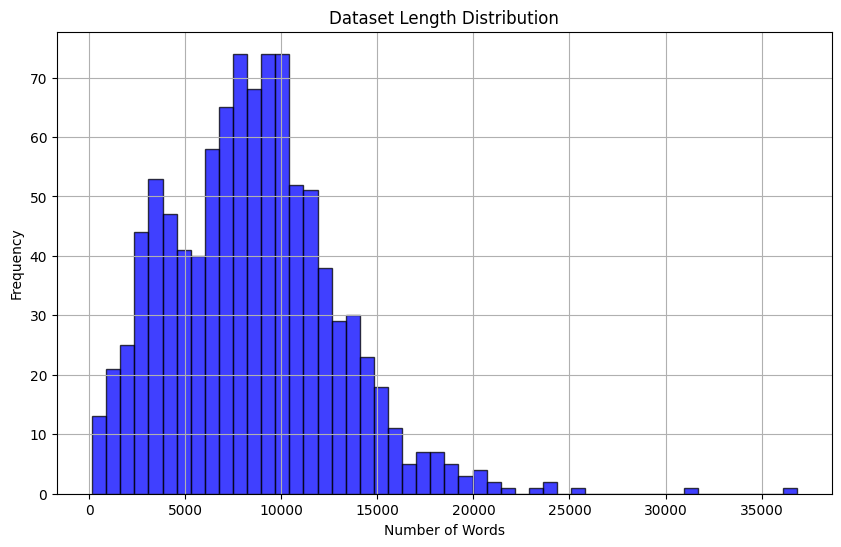

In [4]:
sampled_dataset = sample_dataset(dataset, num_bins=50, n_samples=1000)
plot_lengths(sampled_dataset)

In [2]:
# Extract and remove abstarct from the dataset
import re

def extract_abstract(sample):
    # Regex to extract the abstract
    abstract_pattern = re.compile(r"#{0,6}(\s|.)Abstract\s*\n\n(.*?)(_Keywords.*?|#{0,6}\s*.*Introduction)", re.S | re.I)
    #abstract_pattern = re.compile(r"(#|\*){0,6}\s*Abstract.*\n\n(.*?)(#{0,6}\s*.*Introduction)", re.S | re.I)
    text = sample['text']
    # Extract abstract
    match = abstract_pattern.search(text)
    if match:
        abstract = match.group(1).strip()
    else:
        # Interrupt the abstract to the new paragraph
        abstract_pattern = re.compile(r"(#|\*){0,6}\s*Abstract.*\n\n(.*?)\n\n", re.S)
        match = abstract_pattern.search(text)
        if match:
            abstract = match.group(1).strip()
        else:
            abstract = None

    # Remove abstract from text
    text_without_abstract = abstract_pattern.sub("", text).strip()
    return {'text': text_without_abstract, 'abstract': abstract}





def remove_references(text):
    """
    Removes the references section.
    Detects a heading containing 'references' and captures its content
    until the end of the text.
    """
    # Regex pattern to match a heading containing "references"
    references_pattern = re.compile(r"(\n\s*#{1,6}\s*references\s*\n)(.*$)", re.I | re.S)

    # Search for the references section
    match = references_pattern.search(text)
    if match:
        text = text[:match.start()].strip()  # Keep everything up to the start of the references section
    
    return text


def remove_acknowledgements(text):
    """
    Removes the acknowledgements section.
    Detects a heading containing 'acknowledgements' and captures its content
    until the next section heading.
    """
    # Regex pattern to match a heading containing "acknowledgements"
    acknowledgements_pattern = re.compile(r"(\n\s*#{1,6}\s*acknowledgements\s*\n)(.*?)(?=\n\s*#{1,6}\s*\w+)", re.I | re.S)

    # Search for the acknowledgements section
    match = acknowledgements_pattern.search(text)
    if match:
        text = text[:match.start()].strip()  # Keep everything up to the start of the acknowledgements section
    
    return text


def extract_headings(text):
    """
    Extracts the headings from the text.
    """
    # Regex pattern to match headings
    heading_pattern = re.compile(r"#{1,6}\s*.*", re.I)

    # Find all headings
    headings = heading_pattern.findall(text)
    
    return headings


In [11]:
import re

def find_abstract(sample):
    # Try with the first pattern
    #result = find_section(sample, 'abstract')
    # The first pattern is for extracting all headings
    regex = re.compile(r"#{1,6}\s*.*", re.I)
    
    text = sample['text']
    abstract = None
    headings = list(regex.finditer(text))
    
    section_idx = None
    next_section_idx = None

    # The first try is to find abstract as a section title, we extract all sections and keep as abstract text everything between
    for i, heading in enumerate(headings):
        if 'abstract' in heading.group().lower():
            section_idx = i
            next_section_idx = i + 1
            break
            
    #print(headings[section_idx].group(), headings[next_section_idx].group())
    # If the abstract is not found, try with the second pattern
    if section_idx is None or (next_section_idx < len(headings) and 'introduction' not in headings[next_section_idx].group().lower()):
        # Try finding tha Abstract as newline title
        pattern = re.compile(r"(\bAbstract\b)\n\n*(.*)", re.I)
        match = pattern.search(sample['text'])
        if match:
            abstract = match.group(2)
            text = pattern.sub("", sample['text']).strip()
    else:
        start_section_title = headings[section_idx].start()
        start_section = headings[section_idx].end()
        end_section = headings[next_section_idx].start() if next_section_idx < len(headings) else len(text)
        
        abstract = text[start_section:end_section].strip()
        text = text[:start_section_title] + text[end_section:]
    return {'text': text, 'abstract': abstract}
        

def remove_after_section(sample, section_name='conclusion'):
    """
    Removes everything after the conclusions section.
    Detects a heading containing 'conclusion' and captures its content
    until the next section heading.
    """
    # Regex pattern to match a heading containing "conclusion"
    conclusion_pattern = re.compile(r"(\n\s*#{1,6}\s*.*"+ section_name +".*\n)(.*?)(?=\n\s*#{1,6}\s*\w+)", re.I | re.S)
    
    text = sample['text']

    # Search for the conclusion section
    match = conclusion_pattern.search(text)
    if match:
        after_conclusion = text[match.end():]
        text = text[:match.end()].strip()  # Keep everything up to the end of the conclusion section
    else:
        after_conclusion = None
    
    return {'text': text, 'after_'+section_name: after_conclusion}

def bold_to_heading_with_section(sample, section='Abstract'):
    """
    Converts bold markdown (`**section**`) into heading 1 markdown (`# section`).
    """
    text = sample['text']
    pattern = r'\*\*.*{}.*\*\*'.format(section)
    # Replace the bold text with heading 1 using the provided section
    return {'text': re.sub(pattern, f'# {section}\n', text, re.I)}

def find_section(sample, section_name='abstract'):
    regex = re.compile(r"#{1,6}\s*.*", re.I)
    
    text = sample['text']
    
    headings = list(regex.finditer(text))
    
    section_idx = None
    next_section_idx = None
    for i, heading in enumerate(headings):
        if section_name in heading.group().lower():
            section_idx = i
            next_section_idx = i + 1
            break
    if section_idx is None:
        section = None
    else:
        start_section_title = headings[section_idx].start()
        start_section = headings[section_idx].end()
        end_section = headings[next_section_idx].start() if next_section_idx < len(headings) else len(text)
        
        section = text[start_section:end_section].strip()
        text = text[:start_section_title] + text[end_section:]
    return {section_name: section, 'text': text}

# Process pipeline

In [12]:
from tqdm.notebook import tqdm
import pandas as pd
import datasets

dataset = datasets.load_dataset('eve-esa/eve-cpt-sample-v0.2')['train']

# Remove documents without abstract
dataset_processed = dataset.filter(lambda x: 'abstract' in x['text'].lower())
# Print the number of samples without abstract
print(f"Number of samples without abstract: {len(dataset) - len(dataset_processed)}")
# Convert MD **abstract** to # Abstract
dataset_processed = dataset_processed.map(bold_to_heading_with_section, desc='Converting **abstract** to # Abstract', fn_kwargs={'section': 'Abstract'})
# Convert MD **Introduction** to # Introduction
dataset_processed = dataset_processed.map(bold_to_heading_with_section, fn_kwargs={'section': 'Introduction'}, desc='Converting **abstract** to #Introduction')

# Make a copy of the text column for debugging
dataset_processed = dataset_processed.map(lambda x: {'text': x['text'], 'original_text': x['text']})

# Extract abstract
dataset_processed = dataset_processed.map(find_abstract, desc='Extracting abstract')

## Section cleaning

# Convert MD **conclusion** to # Conclusion
#dataset_processed = dataset_processed.map(bold_to_heading_with_section, fn_kwargs={'section': 'conclusion'})
# Remove after conclusions
#dataset_processed = dataset_processed.map(remove_after_section, fn_kwargs={'section_name': 'conclusion'})
# Remove after references
#dataset_processed = dataset_processed.map(find_section, fn_kwargs={'section_name': 'references'})

data_pd = dataset_processed.to_pandas()

Number of samples without abstract: 588


Extracting abstract: 100%|██████████| 1972/1972 [00:01<00:00, 1284.43 examples/s]


## Preprocessing analysis

In [13]:
# Show samples without abstract
data_pd[data_pd['abstract'].isna()]

,article_title,text,original_text,abstract
96,1204.5531v2,# Morphisms of generalized interval systems an...,# Morphisms of generalized interval systems an...,None
209,0412502v1,**SOLAR ABUNDANCE OF ELEMENTS FROM NEUTRON-CAP...,**SOLAR ABUNDANCE OF ELEMENTS FROM NEUTRON-CAP...,None
234,0603747v1,# Splitting the automorphism group of an abeli...,# Splitting the automorphism group of an abeli...,None
246,0601050v1,"Comments on: ""Increasing destructiveness of tr...","Comments on: ""Increasing destructiveness of tr...",None
251,1103.6012v1,**STATE EQUATION FOR DENSE GASES AND LIQUIDS**...,**STATE EQUATION FOR DENSE GASES AND LIQUIDS**...,None
...,...,...,...,...
1837,mdpi_volume_10_issue_10_article_162,Spectral Invariant Provides a Practical Modeli...,Spectral Invariant Provides a Practical Modeli...,None
1870,mdpi_volume_10_issue_1_article_10,# Trend Detection for the Extent of Irrigated ...,# Trend Detection for the Extent of Irrigated ...,None
1882,mdpi_volume_10_issue_12_article_100,# Developing Land-Use Regression Models to Est...,# Developing Land-Use Regression Models to Est...,None
1899,mdpi_volume_10_issue_12_article_83,Spatiotemporal Evolution of Postseismic Deform...,Spatiotemporal Evolution of Postseismic Deform...,None


In [10]:
# Show samples without conclusion
data_pd[data_pd['after_conclusion'].isna()]

,article_title,text,abstract,after_conclusion,references
2,1207.4754v1,# Scaling mechanism for efficient wavelength c...,Laser-induced ionization is a fundamental tool...,None,"* [1] J. Tate, T. Auguste, H. Muller, P. Salie..."
3,1204.3030v1,# One possible mechanism for massive neutron s...,The recently discovery of a massive neutron st...,None,* (1) P. A. M. Dirac _Natural_**139** (1937) 3...
4,1103.4224v1,# Gas Slit Camera (GSC) onboard MAXI on ISS\n\...,The Gas Slit Camera (GSC) is an X-ray instrume...,None,"* [1]\n* [2]Conner, J. P., Evans, W. D., & Bel..."
13,1112.5284v1,"# From FAIR to RHIC, hyper clusters and an eff...",Two major aspects of strange particle physics ...,None,"* [1] M. Gyulassy and L. McLerran, Nucl. Phys...."
15,1109.3319v1,"# Lines, dots and spirals on Peruvian land\n\n...","The most famous geoglyphs of Peru are the ""Naz...",None,None
...,...,...,...,...,...
1787,mdpi_volume_10_issue_10_article_95,# AMSR2 Soil Moisture Downscaling Using Temper...,Soil moisture (SM) applications in terrestrial...,None,"* Njoku and Enetkhabi 1996 Njoku, E.G.; Entekh..."
1814,mdpi_volume_10_issue_10_article_131,# Decadal Changes of Earth's Outgoing Longwave...,The Earth Radiation Budget (ERB) at the top of...,None,* (1) IPCC. _The Physical Science Basis_; Camb...
1816,mdpi_volume_10_issue_10_article_132,A Novel Integrated Approach of Relevance Vecto...,This research aims at proposing a new artifici...,None,"* Varnes (1978) Varnes, D.J. Slope movement ty..."
1862,mdpi_volume_10_issue_12_article_41,"Correction: Mottus, M. et al. Measurement of D...","In Figures 3 and 4 of [1], we noticed incorrec...",None,"* Mottus et al. (2018) Mottus, M.; Hernandez-C..."


In [16]:
data_pd['text']

0       # SAR Image Segmentation using Vector Quantiza...
1       # Migration of Gas Giant Planets in Gravitatio...
2       # Scaling mechanism for efficient wavelength c...
3       # One possible mechanism for massive neutron s...
4       # Gas Slit Camera (GSC) onboard MAXI on ISS\n\...
                              ...                        
1967    Upscaling Solar-Induced Chlorophyll Fluorescen...
1968    Mapping Root-Zone Soil Moisture Using a Temper...
1969    Landslide Susceptibility Mapping and Compariso...
1970    Evaluation of Sensor and Environmental Factors...
1971    # Generation of High Resolution Vegetation Pro...
Name: text, Length: 1972, dtype: object

In [11]:
with open('sample.txt', 'w') as f:
    f.write(data_pd['text'][1509])

Bin 0: [0, 53]
Count: 62.00
Bin 1: [53, 105]
Count: 191.00
Bin 2: [105, 158]
Count: 270.00
Bin 3: [158, 210]
Count: 343.00
Bin 4: [210, 263]
Count: 365.00
Bin 5: [263, 316]
Count: 322.00
Bin 6: [316, 368]
Count: 177.00
Bin 7: [368, 421]
Count: 70.00
Bin 8: [421, 473]
Count: 32.00
Bin 9: [473, 526]
Count: 11.00
Bin 10: [526, 578]
Count: 6.00
Bin 11: [578, 631]
Count: 5.00
Bin 12: [631, 684]
Count: 1.00
Bin 13: [684, 736]
Count: 2.00
Bin 14: [736, 789]
Count: 0.00
Bin 15: [789, 841]
Count: 0.00
Bin 16: [841, 894]
Count: 0.00
Bin 17: [894, 947]
Count: 0.00
Bin 18: [947, 999]
Count: 1.00
Bin 19: [999, 1052]
Count: 0.00
Bin 20: [1052, 1104]
Count: 1.00
Bin 21: [1104, 1157]
Count: 2.00
Bin 22: [1157, 1210]
Count: 0.00
Bin 23: [1210, 1262]
Count: 2.00
Bin 24: [1262, 1315]
Count: 0.00
Bin 25: [1315, 1367]
Count: 1.00
Bin 26: [1367, 1420]
Count: 2.00
Bin 27: [1420, 1473]
Count: 0.00
Bin 28: [1473, 1525]
Count: 0.00
Bin 29: [1525, 1578]
Count: 3.00
Bin 30: [1578, 1630]
Count: 0.00
Bin 31: [1630,

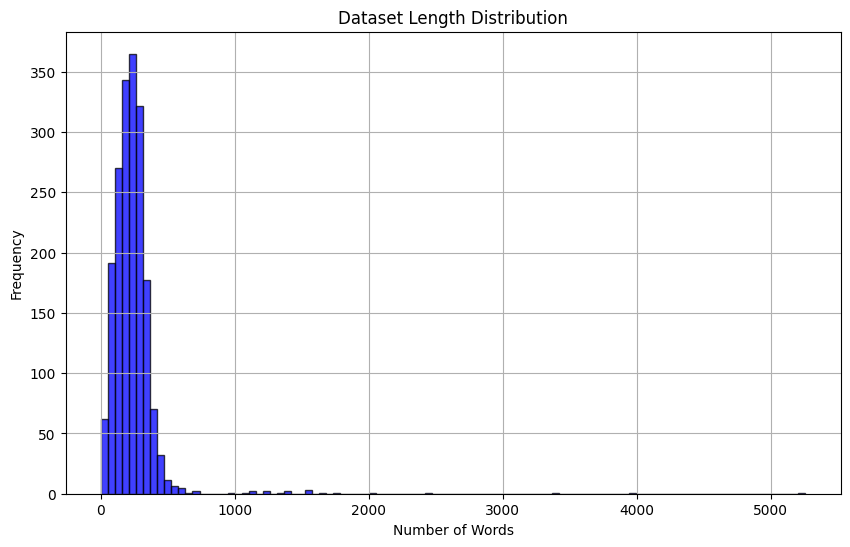

In [26]:
# Filter nan abstracts
data_pd = data_pd[~data_pd['abstract'].isna()]

# Check the length of the abstracts extracted
plot_lengths(data_pd['abstract'], num_bins=100)

In [24]:
# Select all samples with less then 1000 words (probably there were some problems with the extraction)
data_short = data_pd[data_pd['abstract'].apply(lambda x: len(x.split()) < 100)]
data_short

,article_title,text,original_text,abstract
3,1204.3030v1,# One possible mechanism for massive neutron s...,# One possible mechanism for massive neutron s...,The recently discovery of a massive neutron st...
9,0701165v1,Five year ahead prediction of Sea Surface Temp...,Five year ahead prediction of Sea Surface Temp...,There is a clear positive correlation between ...
11,0901.4475v1,# Nuclear Physics of Neutron Stars\n\nJ. Pieka...,# Nuclear Physics of Neutron Stars\n\nJ. Pieka...,Understanding the equation of state (EOS) of c...
12,0709.0050v1,**Interchangeability of Combined Piezoelectroo...,**Interchangeability of Combined Piezoelectroo...,In the present paper the coefficients of piezo...
15,1109.3319v1,"# Lines, dots and spirals on Peruvian land\n\n...","# Lines, dots and spirals on Peruvian land\n\n...","The most famous geoglyphs of Peru are the ""Naz..."
...,...,...,...,...
1485,Atmospheric_Chemistry_and_Physics_volume_11_is...,"Atmos. Chem. Phys., 11, 5457-5469, 2011\n\nwww...","Atmos. Chem. Phys., 11, 5457-5469, 2011\n\nwww...",**[1.5cm]**
1494,mdpi_volume_10_issue_10_article_54,Correction: Assessment of the High Resolution ...,Correction: Assessment of the High Resolution ...,"In Figure 5 of [1], we detected a minor mistak..."
1691,mdpi_volume_10_issue_11_article_93,"# Editorial for Special Issue ""Optical Remote ...","# Editorial for Special Issue ""Optical Remote ...",Boreal forests (or taiga) are the world's larg...
1759,mdpi_volume_10_issue_11_article_6,Erratum: Ramses A.M. et al. Vegetation Charact...,Erratum: Ramses A.M. et al. Vegetation Charact...,"After publication of the research paper [1], t..."


In [25]:
# Print original text to file
with open('sample.txt', 'w') as f:
    f.write(data_short['original_text'][3])

In [56]:
# Try to extract the abstract from the original text
find_abstract({'text': data_short['original_text'][328]})

IndexError: list index out of range

## Save dataset

In [30]:
# Keep only the text and abstract columns
#data_pd = data_pd[['article_title', 'text', 'abstract']]


# Remove text
data_pd = data_pd.drop(columns=['text'])
# Rename original_text to text
data_pd = data_pd.rename(columns={'original_text': 'text'})

# Filter out samples with long abstracts
data_pd = data_pd[data_pd['abstract'].apply(lambda x: len(x.split()) < 1500)]

# Save the processed dataset
data_pd.to_csv('dataset.csv', index=False)

In [32]:
# Upload to the Hugging Face Hub
from datasets import Dataset
hf_dataset = Dataset.from_pandas(data_pd, preserve_index=False)
hf_dataset.push_to_hub('antoniolopez00/eve-cpt-sample-v0.2-summary', private=True)

Uploading the dataset shards: 100%|██████████| 1/1 [00:09<00:00,  9.61s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/antoniolopez00/eve-cpt-sample-v0.2-summary/commit/3e99ae145624c08a2c3be4ccdd5910c2d5351962', commit_message='Upload dataset', commit_description='', oid='3e99ae145624c08a2c3be4ccdd5910c2d5351962', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/antoniolopez00/eve-cpt-sample-v0.2-summary', endpoint='https://huggingface.co', repo_type='dataset', repo_id='antoniolopez00/eve-cpt-sample-v0.2-summary'), pr_revision=None, pr_num=None)

In [34]:
hf_dataset[0]['text']

'# SAR Image Segmentation using Vector Quantization Technique on Entropy Images\n\nDr. H. B. Kekre\n\nComputer Engineering\n\nMPSTME, NMIMS University,\n\nVileparle(w)\n\nMumbai 400-056, India\n\nhbkekre@yahoo.com.\n\nSaylee Gharge\n\nPh.D. Scholar, MPSTME,\n\nNMIMS University,\n\nAssistant Professor, V.E.S.I.T,\n\nMumbai-400071, India\n\nsayleegharge73@yahoo.co.in\n\nTanuja K. Sarode\n\nPh.D. Scholar, MPSTME,\n\nNMIMS University,\n\nAssociate Professor, TSEC,\n\nMumbai 400-050, India\n\ntanuia 0123@yahoo.com\n\n###### Abstract\n\nThe development and application of various remote sensing platforms result in the production of huge amounts of satellite image data. Therefore, there is an increasing need for effective querying and browsing in these image databases. In order to take advantage and make good use of satellite images data, we must be able to extract meaningful information from the imagery.\n\nHence we proposed a new algorithm for SAR image segmentation. In this paper we propose

# Recursive splitting on data


In [3]:
# Load data
import pandas as pd
from datasets import load_dataset

data = load_dataset('eve-esa/eve-cpt-sample-v0.2')['train']

texts = data['text']
sample = texts[0]
print(sample)

# Stochastic inequalities for single-server loss queueing systems

Vyacheslav M. Abramov

School of Mathematical Sciences, Monash University, Building 28M, Clayton Campus, Clayton, VIC 3800, Australia. Vyacheslav.Abramov@sci.monash.edu.auFor the purpose of detailed stochastic analysis of losses we develop the up- and down-crossings approach initiated in a number of earlier works of the author [1]-[4]. It is proved in [3] that if the inter-arrival time distribution of \(GI/M/1/n\) queue belong to the class NBU (NWU), then the number of losses during a busy period is stochastically not smaller (respectively not greater) than the number of offspring in the \(n+1\)st generation of the Galton-Watson branching process with given offspring generating function (see below for the more details). The Galton-Watson branching process is a well-known process having relatively simple explicit expressions for its characteristics. At the same time the explicit results for the number of losses in the \(

In [6]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

headers_to_split_on = [
    ("#", 1),
    ("##", 2),
    ("###", 3),
    ("####", 4),
    ("#####", 5),
    ("######", 6)
]

markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on,
    return_each_line=False,
)

md_header_splits = markdown_splitter.split_text(sample)
md_header_splits

[Document(metadata={'Header 1': 'Stochastic inequalities for single-server loss queueing systems'}, page_content="# Stochastic inequalities for single-server loss queueing systems  \nVyacheslav M. Abramov  \nSchool of Mathematical Sciences, Monash University, Building 28M, Clayton Campus, Clayton, VIC 3800, Australia. Vyacheslav.Abramov@sci.monash.edu.auFor the purpose of detailed stochastic analysis of losses we develop the up- and down-crossings approach initiated in a number of earlier works of the author [1]-[4]. It is proved in [3] that if the inter-arrival time distribution of \\(GI/M/1/n\\) queue belong to the class NBU (NWU), then the number of losses during a busy period is stochastically not smaller (respectively not greater) than the number of offspring in the \\(n+1\\)st generation of the Galton-Watson branching process with given offspring generating function (see below for the more details). The Galton-Watson branching process is a well-known process having relatively sim

In [ ]:
x = {1: 2, 2: 5}

# Take values and keys from the dictionary and order them by keys
values = [x[key] for key in sorted(x.keys())]
keys = sorted(x.keys())

In [8]:
import re

def merge_short_sections(sections, min_length, max_length):
    """
    Merges adjacent sections if they are below min_length,
    ensuring the merged section stays below max_length.

    Args:
        sections (list of tuples): List of (header, text) tuples, where header includes Markdown-style (#, ##, etc.).
        min_length (int): Minimum length for a section before merging.
        max_length (int): Maximum allowed length after merging.

    Returns:
        list of tuples: Processed sections with merged content.
    """

    def get_header_level(header):
        """Extracts the header level from Markdown headers."""
        match = re.match(r"^(#+)", header)
        return len(match.group(1)) if match else float('inf')  # Higher numbers mean deeper levels

    merged_sections = []
    buffer_header, buffer_text = None, ""
    buffer_level = float('inf')



    for doc in sections:
        text = doc.page_content
        header_level = sorted(doc.metadata.keys())[-1]
        #header_level = get_header_level(header)

        if buffer_text and (len(buffer_text) + len(text) <= max_length) and (len(buffer_text) < min_length and header_level >= buffer_level):
            # Merge into previous section if it is too short OR a deeper subsection
            buffer_text += " " + text
        else:
            # Save the previous buffered section
            if buffer_text:
                merged_sections.append((buffer_header, buffer_text))
            # Start a new section
            buffer_header, buffer_text = doc.metadata[header_level], text
            buffer_level = header_level

    # Append the last buffered section
    if buffer_text:
        merged_sections.append((buffer_header, buffer_text))

    return merged_sections


In [30]:
merged_sections = merge_short_sections(md_header_splits, min_length=2000, max_length=100000)

In [29]:
for i, (header, text) in enumerate(merged_sections):
    print('Section {}:'.format(i))
    print(text)

Section 0:
# Stochastic inequalities for single-server loss queueing systems  
Vyacheslav M. Abramov  
School of Mathematical Sciences, Monash University, Building 28M, Clayton Campus, Clayton, VIC 3800, Australia. Vyacheslav.Abramov@sci.monash.edu.auFor the purpose of detailed stochastic analysis of losses we develop the up- and down-crossings approach initiated in a number of earlier works of the author [1]-[4]. It is proved in [3] that if the inter-arrival time distribution of \(GI/M/1/n\) queue belong to the class NBU (NWU), then the number of losses during a busy period is stochastically not smaller (respectively not greater) than the number of offspring in the \(n+1\)st generation of the Galton-Watson branching process with given offspring generating function (see below for the more details). The Galton-Watson branching process is a well-known process having relatively simple explicit expressions for its characteristics. At the same time the explicit results for the number of los